In [1]:
import numpy as np
import random
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/DIP\ Project/dataset/

/content/drive/MyDrive/DIP Project/dataset


In [4]:
EPOCHS = 20
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = './PlantVillage/'
width=256
height=256
depth=3
NO_IMAGES_EACH_SET = 800
PLANTS_TO_CONSIDER = ["Corn"]

In [5]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [7]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = PLANTS_TO_CONSIDER
    print("Root Dir", root_dir)
    # for directory in root_dir :
    #     # remove .DS_Store from list
    #     if directory == ".DS_Store" :
    #         root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print("\n=============================================\n")
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            print(f"No of Images: {len(plant_disease_image_list)}, Selecting Randomly: {NO_IMAGES_EACH_SET}")
            random.shuffle(plant_disease_image_list) 
            ix=1
            for image in plant_disease_image_list[:NO_IMAGES_EACH_SET]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_folder + "_" + plant_disease_folder)
                    if not ix%50:
                      print(ix, end="..")
                    ix+=1
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
Root Dir ['Corn']


[INFO] Processing Corn_Healthy ...
No of Images: 1000, Selecting Randomly: 800
50..100..150..200..250..300..350..400..450..500..550..600..650..700..750..800..

[INFO] Processing Corn_Cercospora_Leaf_Spot ...
No of Images: 513, Selecting Randomly: 800
50..100..150..200..250..300..350..400..450..500..

[INFO] Processing Corn_Common_rust_ ...
No of Images: 1000, Selecting Randomly: 800
50..100..150..200..250..300..350..400..450..500..550..600..650..700..750..800..

[INFO] Processing Corn_Northern_Leaf_Blight ...
No of Images: 985, Selecting Randomly: 800
50..100..150..200..250..300..350..400..450..500..550..600..650..700..750..800..[INFO] Image loading completed


In [8]:
image_size = len(image_list)
image_size

2913

In [9]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
print(label_binarizer.classes_)

['Corn_Corn_Cercospora_Leaf_Spot' 'Corn_Corn_Common_rust_'
 'Corn_Corn_Healthy' 'Corn_Corn_Northern_Leaf_Blight']


In [10]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

In [11]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [12]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [13]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 85, 85, 64)        0

In [15]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [16]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
72/72 [==============================] - 31s 426ms/step - loss: 0.2729 - accuracy: 0.7942 - val_loss: 2.9505 - val_accuracy: 0.2762
Epoch 2/20
72/72 [==============================] - 30s 415ms/step - loss: 0.1871 - accuracy: 0.8538 - val_loss: 0.7997 - val_accuracy: 0.3533
Epoch 3/20
72/72 [==============================] - 30s 417ms/step - loss: 0.1400 - accuracy: 0.8856 - val_loss: 0.7955 - val_accuracy: 0.3911
Epoch 4/20
72/72 [==============================] - 30s 418ms/step - loss: 0.1217 - accuracy: 0.9064 - val_loss: 0.7832 - val_accuracy: 0.4220
Epoch 5/20
72/72 [==============================] - 30s 415ms/step - loss: 0.1137 - accuracy: 0.9125 - val_loss: 1.0243 - val_accuracy: 0.4511
Epoch 6/20
72/72 [==============================] - 30s 414ms/step - loss: 0.1031 - accuracy: 0.9204 - val_loss: 0.4112 - val_accuracy: 0.6741
Epoch 7/20
72/72 [==============================] - 30s 417ms/step

Keys dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


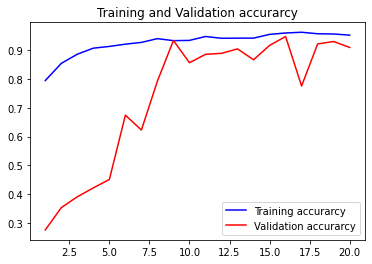

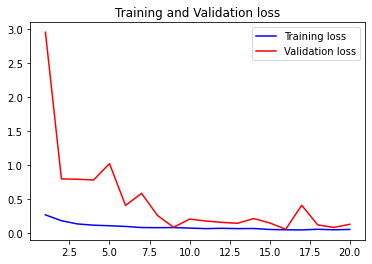

In [17]:
print("Keys", history.history.keys())
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [18]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
19/19 [==============================] - 1s 27ms/step - loss: 0.1348 - accuracy: 0.9091
Test Accuracy: 90.90909361839294


In [19]:
# save the model to disk
# print("[INFO] Saving model...")
# pickle.dump(model,open('cnn_model.pkl', 'wb'))